In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import tqdm

from functools import partial
import pyDOE
from sklearn.gaussian_process.kernels import Matern

from robustGP.SURmodel import AdaptiveStrategy
from robustGP.test_functions import branin_2d, rosenbrock_general
import robustGP.tools as tools
import robustGP.gptools
import robustGP.acquisition.acquisition as ac
import robustGP.enrichment.Enrichment as enrich
import robustGP.optimisers as opt
%matplotlib inline


In [18]:

# plt.style.use("seaborn")
# plt.rc("text.latex", preamble=r"\usepackage{amsmath} \usepackage{amssymb}")
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.serif": ["Computer Modern Roman"],
#     'image.cmap': u'viridis',
#     'figure.figsize': [8, 8],
#     'savefig.dpi': 200
# })

In [19]:
def initialize_branin(initial_design=None):
    """
    Create new instance of AdaptiveStrategy of the Branin 2d function
    with LHS as initial design
    """
    NDIM = 2
    if initial_design is None:
        initial_design = 5 * NDIM
    bounds = np.asarray([(0, 1)] * NDIM)
    initial_design = pyDOE.lhs(
        n=NDIM, samples=initial_design, criterion="maximin", iterations=50
    )
    branin = AdaptiveStrategy(bounds, branin_2d)
    branin.fit_gp(
        initial_design,
        branin.evaluate_function(initial_design),
        Matern(np.ones(NDIM)),
        n_restarts_optimizer=50,
    )
    branin.set_idxU([1], ndim=2)
    return branin

def initialize_rosenbrock(initial_design=None, NDIM=2):
    """
    Create new instance of AdaptiveStrategy of the Branin 2d function
    with LHS as initial design
    """

    def rosenbrock(scaled_input):
        input = 10 * (scaled_input - 0.5)
        return rosenbrock_general(input)

    if initial_design is None:
        initial_design = 5 * NDIM
    
    bounds = np.asarray([(0, 1)] * NDIM)
    initial_design = pyDOE.lhs(
        n=NDIM, samples=initial_design, criterion="maximin", iterations=50
    )
    rosen = AdaptiveStrategy(bounds, rosenbrock)
    rosen.fit_gp(
        initial_design,
        rosen.evaluate_function(initial_design),
        Matern(np.ones(NDIM)),
        n_restarts_optimizer=50,
    )
    rosen.set_idxU([1], ndim=2)
    return rosen

bounds = np.asarray([[0, 1], [0, 1]])
# For plots
npts = 2**5
x, y = np.linspace(0, 1, npts), np.linspace(0, 1, npts)
(XY, (xmg, ymg)) = tools.pairify((x, y))
xl, yl = np.linspace(0, 1, 500), np.linspace(0, 1, 500)
(XYl, (xmgl, ymgl)) = tools.pairify((xl, yl))

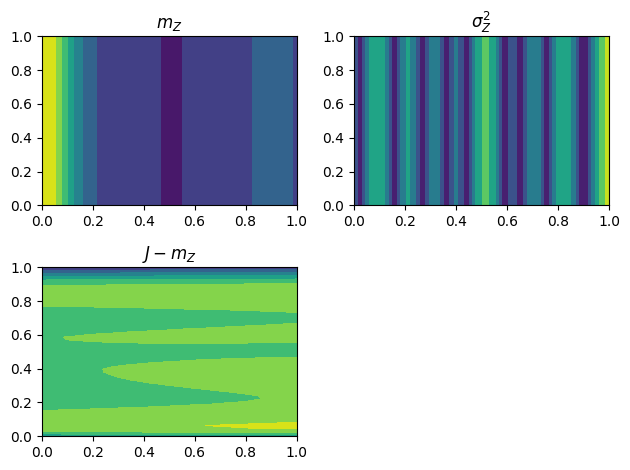

In [20]:
branin = initialize_rosenbrock()
m, s = branin.predict(XY, return_std=True)
plt.subplot(2, 2, 1)
plt.contourf(x, y, m.reshape(npts, npts).T)
plt.title(r"$m_Z$")
plt.subplot(2, 2, 2)
plt.contourf(x, y, s.reshape(npts, npts).T)
plt.title(r"$\sigma^2_Z$")
plt.subplot(2, 2, 3)
plt.contourf(x, y, (m.reshape(npts, npts) - branin.function(XY).reshape(npts, npts)))
plt.title(r"$J - m_Z$")
plt.tight_layout()

In [21]:
def conditional_minimisers_diag(arg):
    u_array = np.linspace(0, 1, 2**7)
    th_star = []
    J_star = []
    th_star_true = []
    J_star_true = []
    pbar = tqdm.tqdm(u_array, desc="J* and theta* computation", leave=False)
    for u in pbar:
        cond_min_true = arg.get_conditional_minimiser_true(u)
        cond_min = arg.get_conditional_minimiser(u)
        th_star.append(cond_min.x)
        th_star_true.append(cond_min_true.x)
        J_star.append(cond_min.fun)
        J_star_true.append(cond_min_true.fun)
    return {"J_star_true": J_star_true, "theta_star_true": th_star_true, "J_star": J_star, "theta_star": th_star}

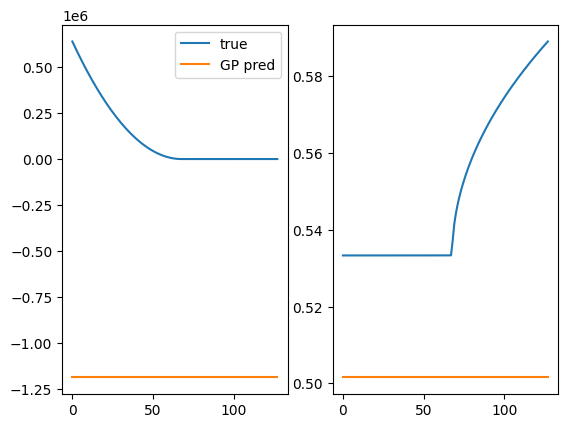

In [22]:
cond_min_dict = conditional_minimisers_diag(branin)
J_star_true, th_star_true, J_star, th_star = cond_min_dict['J_star_true'], cond_min_dict['theta_star_true'], cond_min_dict['J_star'], cond_min_dict['theta_star']

plt.subplot(1, 2, 1)
plt.plot(J_star_true, label='true')
plt.plot(J_star, label='GP pred')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(th_star_true)
plt.plot(th_star)

In [24]:
maximum_variance = enrich.OneStepEnrichment(bounds)
maximum_variance.set_optim(opt.optimize_with_restart, **{"bounds": bounds, "nrestart": 20})

def variance(arg, X):
    return arg.predict(X, return_std=True)[1] ** 2

maximum_variance.set_criterion(variance, maxi=True)
branin.set_enrichment(maximum_variance)

def callback(arg, i):
    # mdel, sdel = arg.predict_GPdelta(XY, alpha=2)
    # m, s = arg.predict(XY, return_std=True)
    s , sdel = 1.0, 10.
    # cond_min_dict = conditional_minimisers_diag(arg)
    JstarL2 = np.sum((np.array(cond_min_dict['J_star']) - np.array(cond_min_dict['J_star_true']))**2)
    theta_star_L2 = np.sum((np.array((cond_min_dict['theta_star']) - np.array(cond_min_dict['theta_star_true']))**2))
    return np.sum(s**2), np.sum(sdel**2), JstarL2, theta_star_L2


logs = branin.run(Niter=100)

100%|██████████| 100/100 [05:06<00:00,  3.06s/it]


Text(0.5, 1.0, '$J - m_Z$')

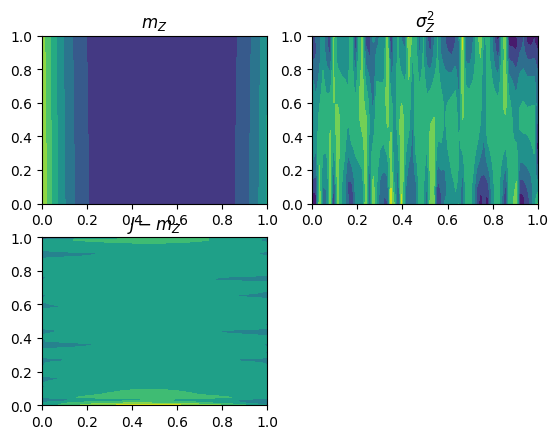

In [25]:
m, s = branin.predict(XY, return_std=True)
plt.subplot(2, 2, 1)
plt.contourf(x, y, m.reshape(npts, npts).T)
plt.title(r"$m_Z$")
plt.subplot(2, 2, 2)
plt.contourf(x, y, s.reshape(npts, npts).T)
plt.title(r"$\sigma^2_Z$")
plt.subplot(2, 2, 3)
plt.contourf(x, y, (m.reshape(npts, npts) - branin.function(XY).reshape(npts, npts)))
plt.title(r"$J - m_Z$")

In [26]:
_, _, Js_l2, ts_l2 = zip(*logs)

ValueError: not enough values to unpack (expected 4, got 0)

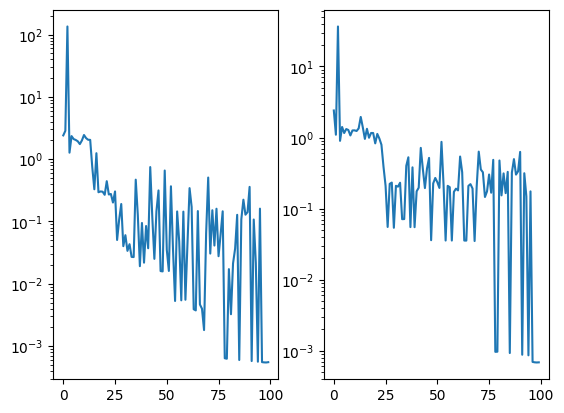

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(Js_l2)
plt.yscale('log')
plt.subplot(1, 2, 2)
plt.plot(ts_l2)
plt.yscale('log')